In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import folium
import geopandas as gpd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib import font_manager
font_manager.fontManager.addfont("./fonts/times.ttf")

MIN_LAT = 22.5311
MAX_LAT = 22.5517
MIN_LNG = 114.0439
MAX_LNG = 114.0633

%pwd

'/home/cseadmin/dz/TrafficFlowModel/scripts'

In [2]:
taxi_data_path = os.walk("../data/taxi")
all_files = []
for root,ds,fs in taxi_data_path:
    days = []
    for f in fs:
        full_path = os.path.join(root, f)
        days.append(full_path)
    if len(days)==0:
        continue
    all_files.append(days)
    
all_files.sort()
for day in all_files:
    day.sort()
all_files[:2]

[['../data/taxi/202006/2020-06-01/2020-06-01_0',
  '../data/taxi/202006/2020-06-01/2020-06-01_1',
  '../data/taxi/202006/2020-06-01/2020-06-01_2',
  '../data/taxi/202006/2020-06-01/2020-06-01_3',
  '../data/taxi/202006/2020-06-01/2020-06-01_4',
  '../data/taxi/202006/2020-06-01/2020-06-01_5',
  '../data/taxi/202006/2020-06-01/2020-06-01_6',
  '../data/taxi/202006/2020-06-01/2020-06-01_7',
  '../data/taxi/202006/2020-06-01/2020-06-01_8',
  '../data/taxi/202006/2020-06-01/2020-06-01_9'],
 ['../data/taxi/202006/2020-06-02/2020-06-02_0',
  '../data/taxi/202006/2020-06-02/2020-06-02_1',
  '../data/taxi/202006/2020-06-02/2020-06-02_2',
  '../data/taxi/202006/2020-06-02/2020-06-02_3',
  '../data/taxi/202006/2020-06-02/2020-06-02_4',
  '../data/taxi/202006/2020-06-02/2020-06-02_5',
  '../data/taxi/202006/2020-06-02/2020-06-02_6',
  '../data/taxi/202006/2020-06-02/2020-06-02_7',
  '../data/taxi/202006/2020-06-02/2020-06-02_8',
  '../data/taxi/202006/2020-06-02/2020-06-02_9']]

In [3]:
names = [
    "sys_time", "license_number", "lng", "lat", "gps_time", "EMPTY1", "speed",
    "direction", "car_status", "alarm_status", "EMPTY2", "EMPTY3",
    "license_color", "recorder_speed", "mileage", "height", "EMPTY4"
]

file_0601=all_files[1]

df_0601=pd.DataFrame()
for taxi_file in file_0601:
    df_0601=df_0601.append(pd.read_csv(taxi_file, names=names)[["license_number", "gps_time", "lat", "lng", "speed"]])

print(len(df_0601))
df_0601

97453725


license_number             gps_time        lat         lng  speed
0             粤BD77165  2020-06-01 23:59:49  22.610820  113.920950     61
1              粤B7ZY30  2000-01-01 00:00:00   0.000000    0.000000      0
2             粤BD02973  2020-06-01 23:59:50  22.726140  114.265140      0
3              粤B0NC67  2000-01-01 00:00:00   0.000000    0.000000      0
4             粤BDR7746  2020-06-01 23:59:48  22.569310  114.099100     58
...                ...                  ...        ...         ...    ...
7453720       粤BDA1040  2020-06-02 23:59:51  22.556341  113.980740      0
7453721        粤BV2N51  2000-01-01 00:00:00   0.000000    0.000000      0
7453722       粤BD98097  2020-06-02 23:59:48  22.617779  113.934586     65
7453723        粤BV1P31  2000-01-01 00:00:00   0.000000    0.000000      0
7453724       粤BD75949  2020-06-02 23:59:51  22.589676  114.050040     58

[97453725 rows x 5 columns]

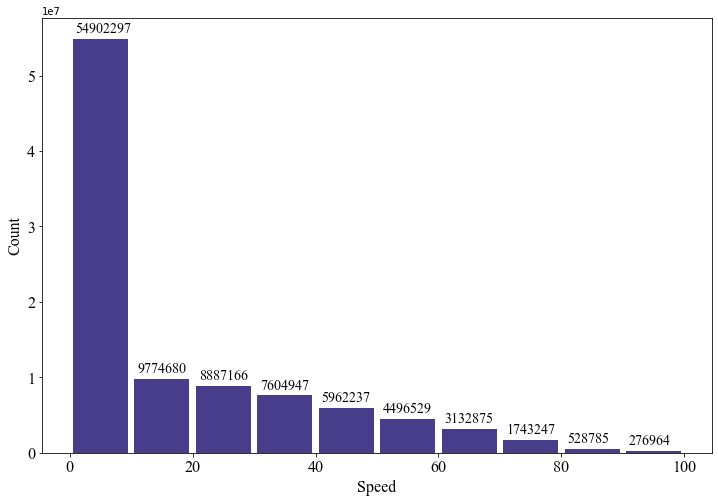

In [4]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Speed", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Count", fontdict={"family" : "Times New Roman", "size": 16})
density, bins, _=plt.hist(df_0601.speed, bins=None, range=(0, 100), histtype="bar", rwidth=0.9, color="darkslateblue")
count, _ = np.histogram(df_0601.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+1, y+0.8e6, num, fontsize=14, fontproperties = "Times New Roman") # x,y,str
plt.savefig("./images/speed_hist_before.png", dpi=300, bbox_inches="tight")
plt.show();

In [5]:
SZ_MINLON = 113.751647
SZ_MAXLON = 114.622924
SZ_MINLAT = 22.400047
SZ_MAXLAT = 22.855425

df_0601_clean=df_0601.drop_duplicates()
df_0601_clean=df_0601_clean.loc[(df_0601_clean["lat"]>=SZ_MINLAT) & (df_0601_clean["lat"]<=SZ_MAXLAT) &
                    (df_0601_clean["lng"]>=SZ_MINLON) & (df_0601_clean["lng"]<=SZ_MAXLON) &
                    (df_0601_clean["gps_time"]>="2020-06-01") & (df_0601_clean["gps_time"]<"2020-06-02") &
                    (df_0601_clean["speed"]<150) & (df_0601_clean["speed"]>0)]

df_0601_clean

license_number             gps_time        lat        lng  speed
0             粤BD77165  2020-06-01 23:59:49  22.610820  113.92095     61
4             粤BDR7746  2020-06-01 23:59:48  22.569310  114.09910     58
6             粤BDG2918  2020-06-01 23:59:49  22.570156  113.92883     66
8             粤BD47906  2020-06-01 23:59:51  22.583370  113.86624     18
10            粤BA31863  2020-06-01 23:59:48  22.547894  114.12541     39
...                ...                  ...        ...        ...    ...
7428428       粤BDD0757  2020-06-01 13:00:17  22.713800  114.31099     16
7428432       粤BDD0757  2020-06-01 13:00:22  22.713871  114.31091      9
7428436       粤BDD0757  2020-06-01 13:00:42  22.712784  114.31088     33
7440834       粤BDD0757  2020-06-01 13:01:51  22.711248  114.30961     22
7447124       粤BDD0757  2020-06-01 13:03:43  22.713396  114.30520      8

[270786 rows x 5 columns]

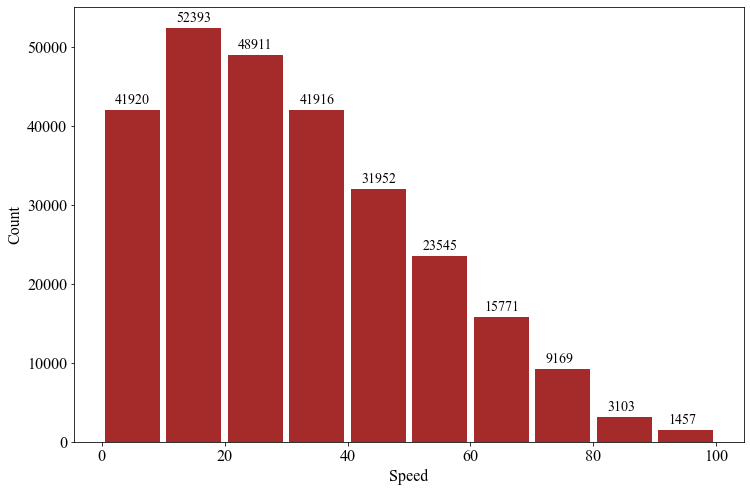

In [6]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Speed", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Count", fontdict={"family" : "Times New Roman", "size": 16})
density, bins, _=plt.hist(df_0601_clean.speed, bins=None, range=(0, 100), histtype="bar", rwidth=0.9, color="brown")
count, _ = np.histogram(df_0601_clean.speed, bins)
for x, y, num in zip(bins, density, count):
    if num != 0:
        plt.text(x+2.2, y+800, num, fontsize=14, fontproperties = "Times New Roman") # x,y,str
plt.savefig("./images/speed_hist_after.png", dpi=300, bbox_inches="tight")
plt.show();

---

In [39]:
map=folium.Map(location=[22.565050, 114.045616], 
               zoom_start=12, 
               tiles='OpenStreetMap'
               )
n=10
file_path="../data/taxi_after_proc/merged/"

count=0
for taxi_file in os.listdir(file_path):
    if os.path.getsize(os.path.join(file_path, taxi_file))<100:
        continue
    
    df_taxi=pd.read_csv(os.path.join(file_path, taxi_file))
    gps_list=df_taxi[["lat", "lng"]].values.tolist()
    
    for gps in gps_list:
        trash=folium.Circle(gps, radius=10, weight=5, color="blue").add_to(map)

    count+=1
    if count>n:
        break

trash=folium.Rectangle([(MIN_LAT, MIN_LNG), (MAX_LAT, MAX_LNG)], color="red", weight=5).add_to(map)
map

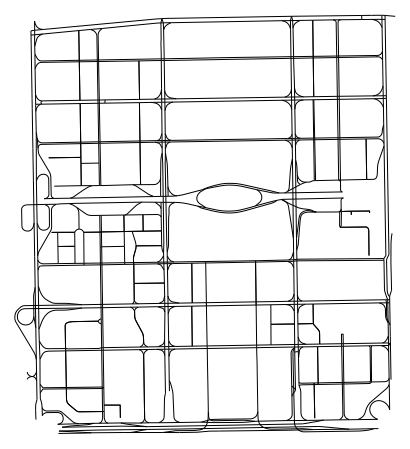

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

{'n': 532,
 'm': 906,
 'k_avg': 3.406015037593985,
 'edge_length_total': 97780.85099999986,
 'edge_length_avg': 107.92588410596011,
 'streets_per_node_avg': 3.2857142857142856,
 'streets_per_node_counts': {0: 0, 1: 10, 2: 0, 3: 350, 4: 172},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.018796992481203006,
  2: 0.0,
  3: 0.6578947368421053,
  4: 0.3233082706766917},
 'intersection_count': 522,
 'street_length_total': 90567.6929999999,
 'street_segment_count': 843,
 'street_length_avg': 107.43498576512444,
 'circuity_avg': 1.0334599830309064,
 'self_loop_proportion': 0.0}

In [35]:
futian_graph_drive=ox.graph_from_bbox(MIN_LAT, MAX_LAT, MIN_LNG, MAX_LNG, network_type="drive")

ox.plot_graph(futian_graph_drive, figsize=(12, 8), node_size=0, node_alpha=0.8, bgcolor="white", node_color="black", edge_color="black", show=True, save=True, filepath="./images/graph_before.png", dpi=300)
ox.basic_stats(futian_graph_drive)

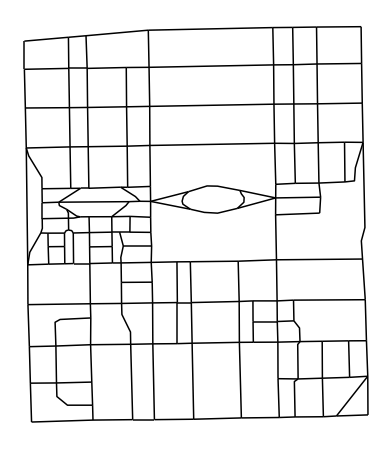

In [45]:
gdf = gpd.read_file("../data/sz_taxi_202006/gis/shenzhen.shp")
gdf.drop(columns="id", inplace=True)
gdf["fid"]=range(len(gdf))

ax=gdf.plot(color="black", figsize=(12, 8))
ax.set_axis_off()
ax.plot()
plt.savefig("./images/graph_after.png", dpi=300)
plt.show();

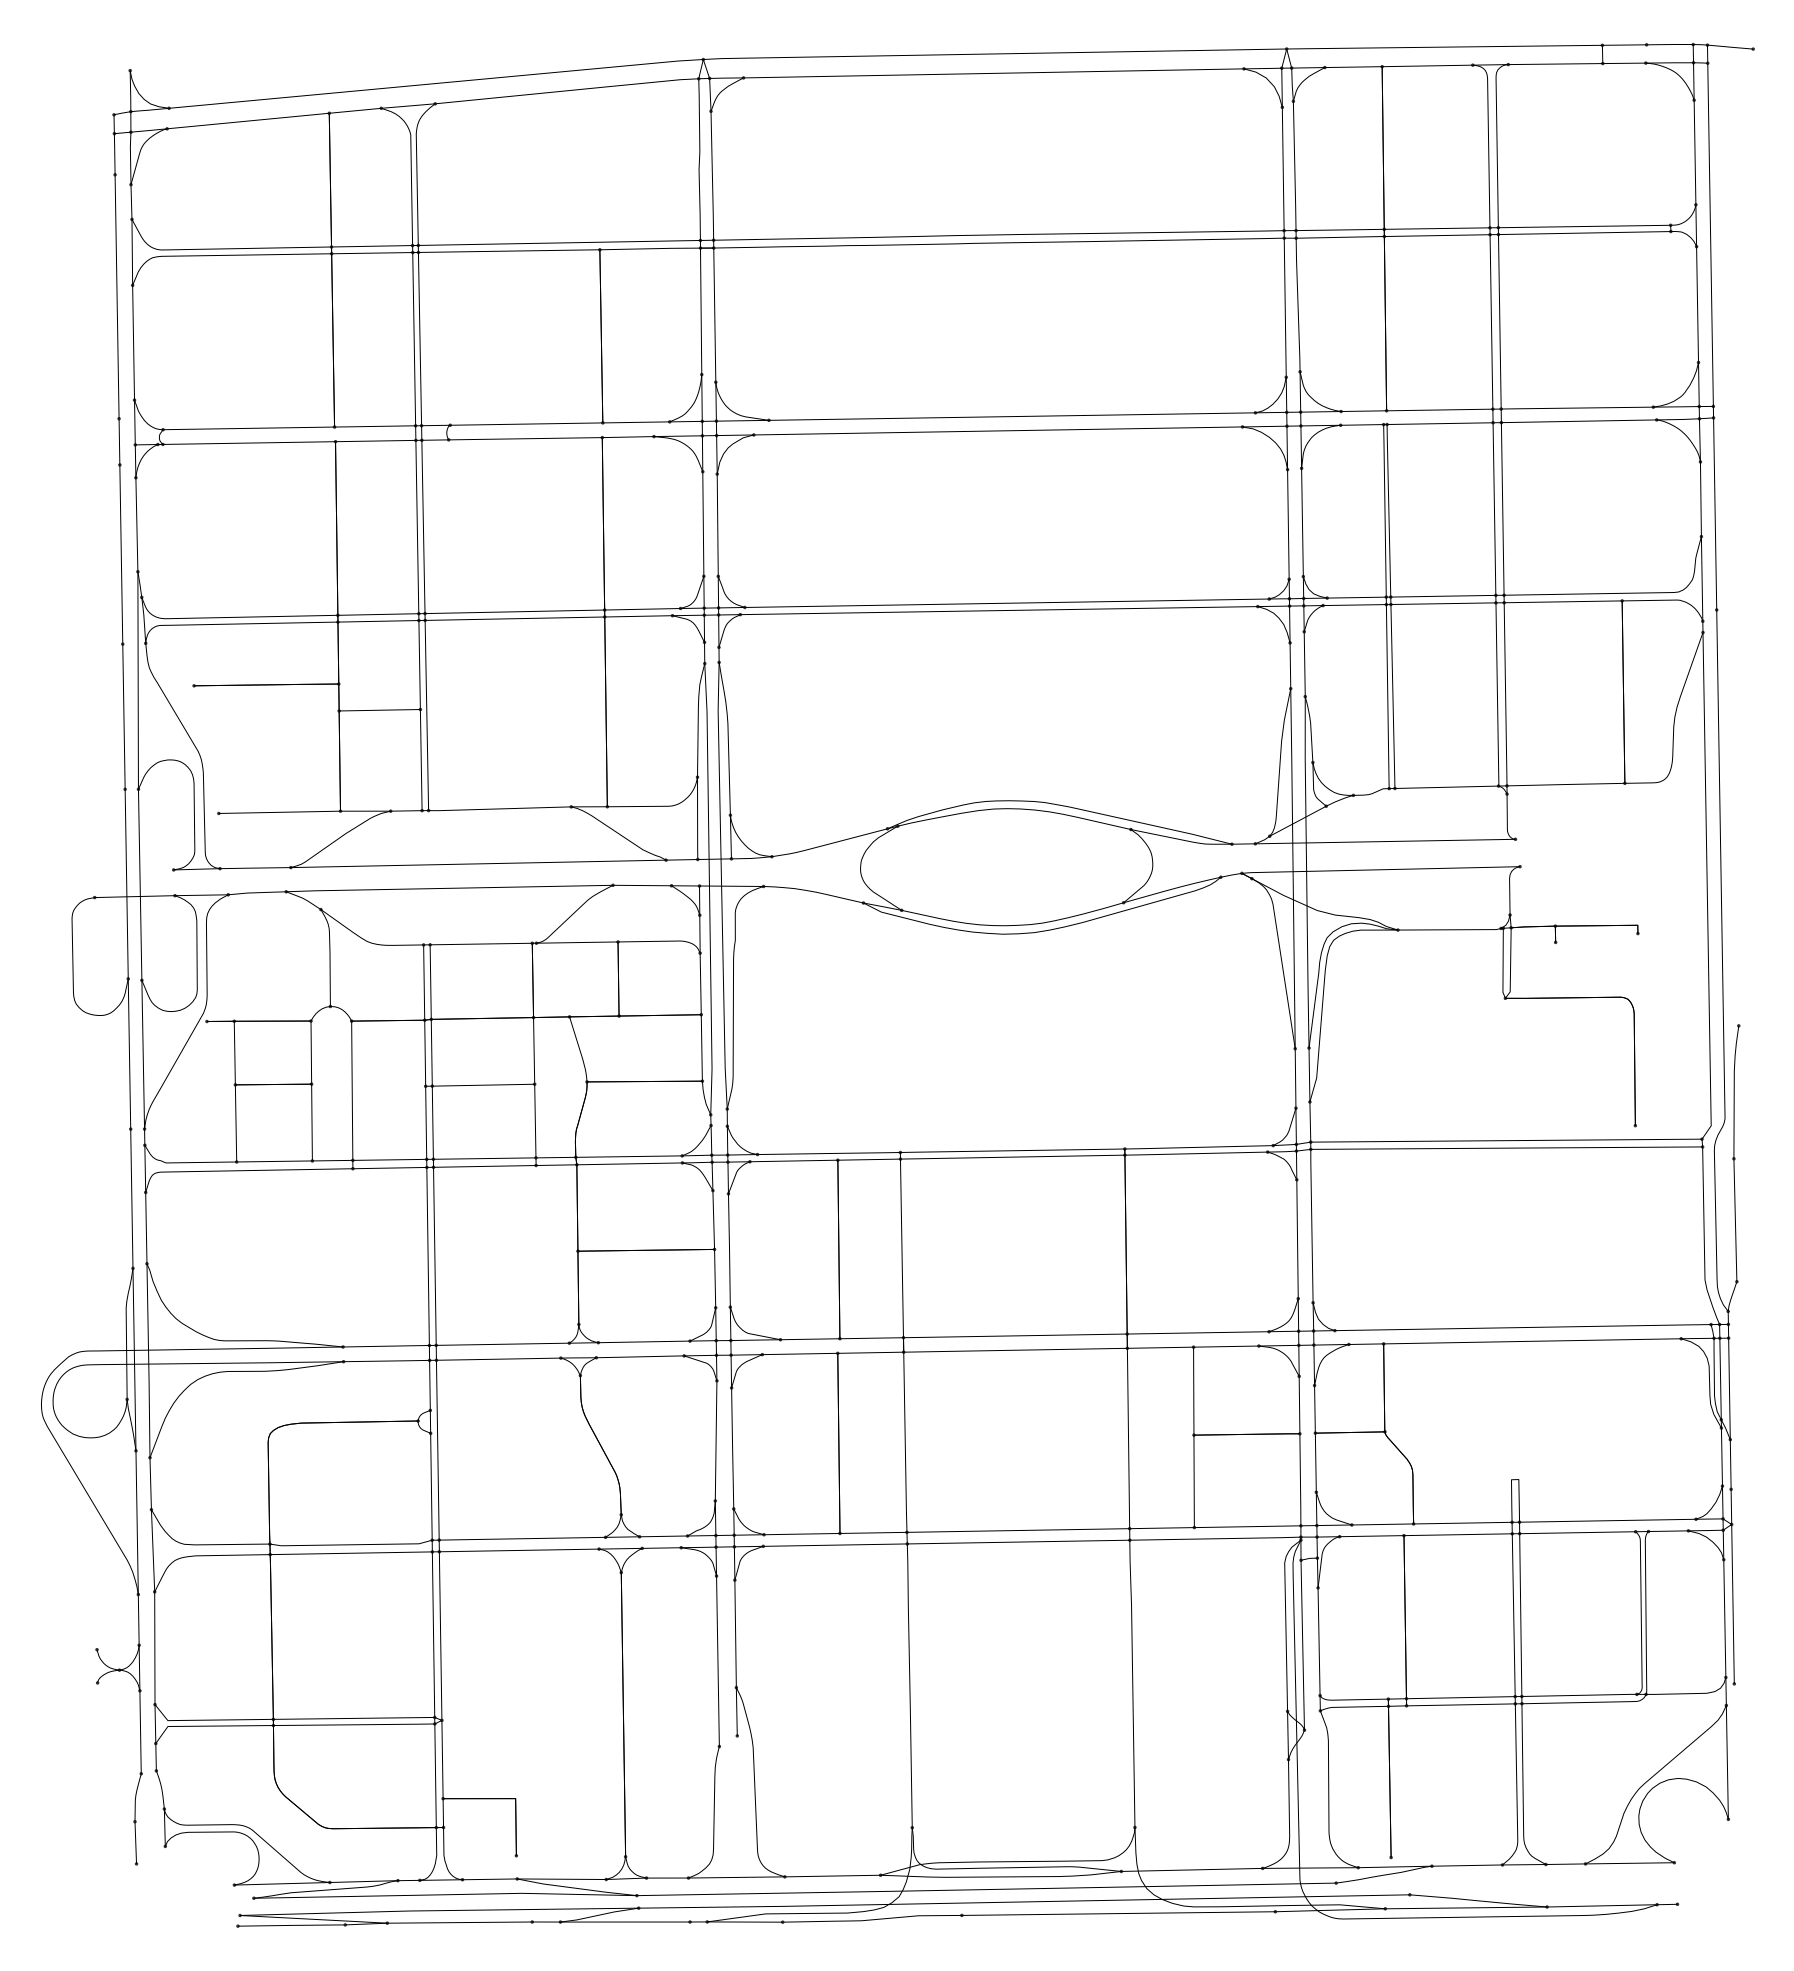

(<Figure size 3456x2592 with 1 Axes>, <AxesSubplot:>)

{'n': 532,
 'm': 906,
 'k_avg': 3.406015037593985,
 'edge_length_total': 97780.85099999986,
 'edge_length_avg': 107.92588410596011,
 'streets_per_node_avg': 3.2857142857142856,
 'streets_per_node_counts': {0: 0, 1: 10, 2: 0, 3: 350, 4: 172},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.018796992481203006,
  2: 0.0,
  3: 0.6578947368421053,
  4: 0.3233082706766917},
 'intersection_count': 522,
 'street_length_total': 90567.6929999999,
 'street_segment_count': 843,
 'street_length_avg': 107.43498576512444,
 'circuity_avg': 1.0334599830309064,
 'self_loop_proportion': 0.0}

In [5]:
futian_graph_drive=ox.graph_from_bbox(MIN_LAT, MAX_LAT, MIN_LNG, MAX_LNG, network_type="drive")

ox.plot_graph(futian_graph_drive, figsize=(48, 36), node_size=12, node_alpha=0.8, bgcolor="white", node_color="black", edge_color="black", show=True)
ox.basic_stats(futian_graph_drive)

---

In [7]:
embed_dim_list = [16, 32, 64, 128]
hidden_dim_list = [32, 64, 128, 256]
batch_size_list = [64, 128, 256, 512]
lr_list = [0.001, 0.0001]

In [8]:
# embed_dim=64
hidden_dim=256
batch_size=256
lr=0.0001

acc_embed_dim_list=[]
for embed_dim in embed_dim_list:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_embed_dim_list.append(acc)

acc_embed_dim_list

[0.71838, 0.72825, 0.73012, 0.7331]

In [9]:
# embed_dim=16
# # hidden_dim=256
# batch_size=256
# lr=0.0001

# acc_hidden_dim_list=[]
# for hidden_dim in hidden_dim_list:
#     with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
#         acc=f.readlines()[-1].split(" ")[-2]
#         acc=float(acc)
        
#         acc_hidden_dim_list.append(acc)

# acc_hidden_dim_list

In [10]:
# embed_dim=32
# hidden_dim=256
batch_size=256
lr=0.0001

acc_hidden_dim_list=[]
for embed_dim, hidden_dim in [(16, 32), (32, 64), (64, 128), (64, 256)]:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_hidden_dim_list.append(acc)

acc_hidden_dim_list

[0.71208, 0.72648, 0.72891, 0.73012]

In [11]:
embed_dim=64
hidden_dim=256
# batch_size=256
lr=0.0001

acc_batch_size_list=[]
for batch_size in batch_size_list:
    with open(os.path.join("../model/log/", f"lstm_ed{embed_dim}_hd{hidden_dim}_bs{batch_size}_lr{lr}.log")) as f:
        acc=f.readlines()[-1].split(" ")[-2]
        acc=float(acc)
        
        acc_batch_size_list.append(acc)

acc_batch_size_list

[0.73185, 0.73303, 0.73012, 0.73349]

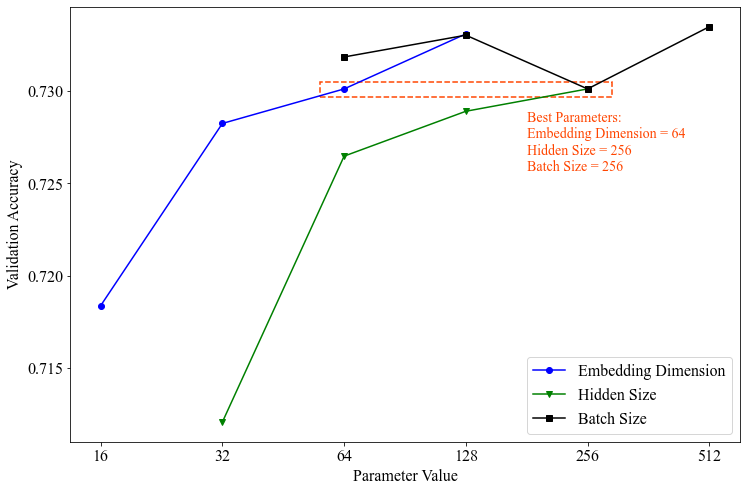

In [12]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("Parameter Value", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Validation Accuracy", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(list(map(str, embed_dim_list)), acc_embed_dim_list, "bo-", label="Embedding Dimension")
plt.plot(list(map(str, hidden_dim_list)), acc_hidden_dim_list, "gv-", label="Hidden Size")
plt.plot(list(map(str, batch_size_list)), acc_batch_size_list, "ks-", label="Batch Size")
plt.gca().add_patch(plt.Rectangle((1.8, 0.7297), 2.4, 0.0008, color="orangered", fill=False, lw=1.5, ls="--"))
txt="Best Parameters:\nEmbedding Dimension = 64\nHidden Size = 256\nBatch Size = 256"
plt.text(3.5, 0.7257, txt, fontsize=14, fontproperties = "Times New Roman", color="orangered")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="lower right")
plt.savefig("./images/next-hop_param.png", dpi=300, bbox_inches="tight")
plt.show();

In [13]:
k_list=list(map(str, range(2, 21)))

In [14]:
flow_step3_list=[]
flow_step6_list=[]
flow_step12_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/3", f"STGCN3_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        flow_step3_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/6", f"STGCN6_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        flow_step6_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_flow_knn/12", f"STGCN12_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        flow_step12_list.append(mape)

flow_step3_list[0]
flow_step6_list[0]
flow_step12_list[0]

33.0792281649

33.6708196002

35.3071687839

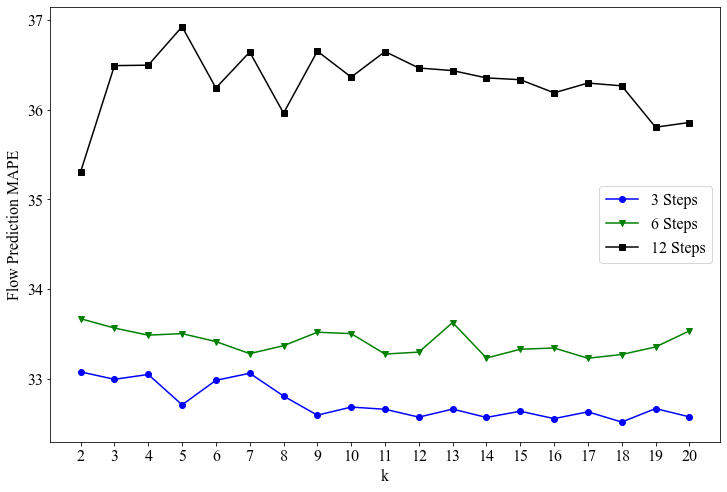

In [15]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Flow Prediction MAPE", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(k_list, flow_step3_list, "bo-", label="3 Steps")
plt.plot(k_list, flow_step6_list, "gv-", label="6 Steps")
plt.plot(k_list, flow_step12_list, "ks-", label="12 Steps")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
plt.savefig("./images/k-flow.png", dpi=300, bbox_inches='tight')
plt.show();

In [16]:
speed_step3_list=[]
speed_step6_list=[]
speed_step12_list=[]

for k in k_list:
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/3", f"STGCN3_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step3_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/6", f"STGCN6_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step6_list.append(mape)
        
    with open(os.path.join("../../DL-Traff-Graph/log_speed_knn/12", f"STGCN12_{k}.log"), "r") as f:
        line=f.readlines()[-3]
        mape=float(line.split(",")[-1].strip("\n"))
        
        speed_step12_list.append(mape)

speed_step3_list[0]
speed_step6_list[0]
speed_step12_list[0]

23.7785044325

23.950744735

24.0358457569

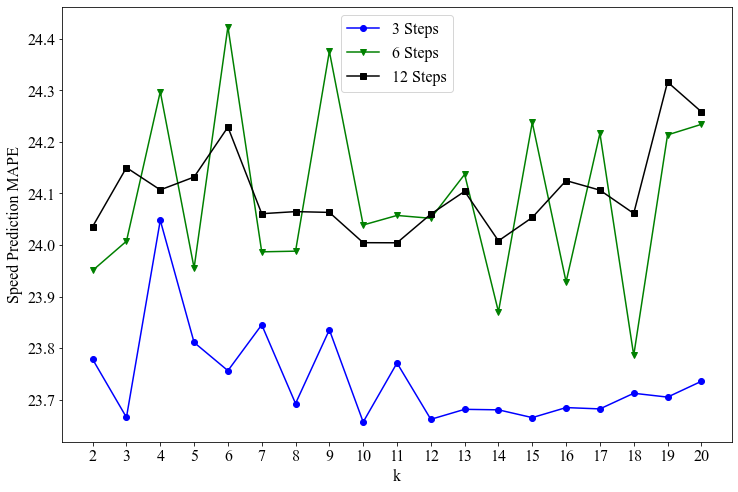

In [17]:
plt.figure(figsize=(12, 8))
plt.yticks(fontproperties = "Times New Roman", size = 16)
plt.xticks(fontproperties = "Times New Roman", size = 16)
plt.xlabel("k", fontdict={"family" : "Times New Roman", "size": 16})
plt.ylabel("Speed Prediction MAPE", fontdict={"family" : "Times New Roman", "size": 16})
plt.plot(k_list, speed_step3_list, "bo-", label="3 Steps")
plt.plot(k_list, speed_step6_list, "gv-", label="6 Steps")
plt.plot(k_list, speed_step12_list, "ks-", label="12 Steps")
plt.legend(prop={"family" : "Times New Roman", "size": 16}, loc="best")
plt.savefig("./images/k-speed.png", dpi=300, bbox_inches='tight')
plt.show();

---

In [256]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
embedding_matrix=np.load("../model/saved/embedding_matrix.npy")

tsne=TSNE(n_components=2, init="pca", n_iter=5000, n_jobs=-1)
tsne_res=tsne.fit_transform(embedding_matrix)
print(tsne_res)

[[-2.54701996e+00 -1.67932212e+00]
 [-3.79728580e+00  8.89035702e+00]
 [-2.22451878e+00  8.09923172e+00]
 [-2.04080462e+00  9.62593365e+00]
 [ 4.25462151e+00 -4.47675586e-01]
 [ 5.36991072e+00  6.92767906e+00]
 [-1.26514292e+00 -5.70044231e+00]
 [-7.94970989e+00 -7.66403580e+00]
 [ 2.41967821e+00  3.45136300e-02]
 [-4.78674793e+00 -3.54207230e+00]
 [-1.09620547e+00  3.86654846e-02]
 [ 5.72676945e+00  8.01826191e+00]
 [ 6.03929472e+00  1.99632561e+00]
 [ 1.41583097e+00 -2.82910317e-01]
 [-1.51678314e+01  9.00963974e+00]
 [-6.63977098e+00  1.36030378e+01]
 [-1.77674472e+00  1.34162111e+01]
 [ 4.03269339e+00  7.55765200e+00]
 [-1.62384903e+00  7.39158726e+00]
 [-6.06077492e-01  6.53413630e+00]
 [-4.70955908e-01 -1.15512180e+01]
 [-1.22080841e+01  7.27895069e+00]
 [-7.33696365e+00  4.63888264e+00]
 [-1.15652490e+00  6.77202511e+00]
 [-4.69128847e+00  9.27716446e+00]
 [ 2.64430285e+00 -3.40313971e-01]
 [-1.72836173e+00 -5.81362677e+00]
 [-2.95969772e+00  1.50035419e+01]
 [-3.77620292e+00 -1

In [231]:
a=np.array([[1, 1], [2, 2], [3, 3]])
scaler=StandardScaler()
a=scaler.fit_transform(a.T).T
a
scaler.mean_

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

array([1., 2., 3.])

In [244]:
cor_matrix=embedding_matrix @ embedding_matrix.T
for i in range(len(cor_matrix)):
    cor_matrix[i][i]=0

# scaler=StandardScaler()
scaler=MinMaxScaler()
cor_matrix=scaler.fit_transform(cor_matrix.T).T

# cor_matrix-=np.min(cor_matrix, axis=1).reshape(-1, 1)
# cor_matrix/=np.max(cor_matrix, axis=1).reshape(-1, 1)
# cor_matrix=np.nan_to_num(cor_matrix)
for i in range(len(cor_matrix)):
    cor_matrix[i][i]=1
cor_matrix

array([[1.        , 0.4786337 , 0.6966655 , ..., 0.396482  , 0.6663878 ,
        0.48536363],
       [0.49207893, 1.        , 0.35265756, ..., 0.43834767, 0.62276953,
        0.49911582],
       [0.66114336, 0.31204852, 1.        , ..., 0.33605027, 0.5632547 ,
        0.45121023],
       ...,
       [0.37678337, 0.4064558 , 0.35071367, ..., 1.        , 0.50155115,
        0.46250996],
       [0.6593773 , 0.5962844 , 0.5907714 , ..., 0.51809645, 1.        ,
        0.47740674],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

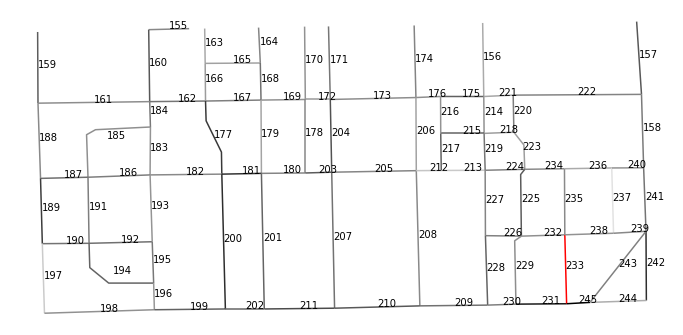

In [263]:
DATA_PATH = "../data/"
TAXI_DATA_PATH = "../data/taxi_after_proc/clean202006"
DATASET = "sz_taxi_202006"
df_edges = gpd.GeoDataFrame.from_file(os.path.join(DATA_PATH, DATASET, f"fmm_{DATASET}", "edges.shp"))

# color0=list(zip(cor_matrix[0], cor_matrix[0], cor_matrix[0], np.ones(len(cor_matrix[0]))))
# color0=list(zip(np.zeros(len(cor_matrix[0])), np.zeros(len(cor_matrix[0])), cor_matrix[0], np.ones(len(cor_matrix[0]))))
# color0=list(zip(np.zeros(len(cor_matrix[0])), np.zeros(len(cor_matrix[0])), cor_matrix[0], np.ones(len(cor_matrix[0]))))
# df_edges["color0"]=color0

def get_color(row):
    # val=-1+2*row.cor
    # if val>0:
    #     row["color"]=(val, 0, 0, 1)
    # else:
    #     row["color"]=(0, 0, -val, 1)
    val=1-row.cor
    # if val>=0.5:
    #     val*=1.2
    #     if val>1:
    #         val=1
    # else:
    #     val*=0.8
    row["color"]=(val, val, val, 1)
        
    return row

n=233
df_edges["cor"]=cor_matrix[n]
df_edges=df_edges.apply(get_color, axis=1)
df_edges.at[n, "color"]=(1, 0, 0, 1)
if n<246:
    df_edges.at[n+246, "color"]=(1, 0, 0, 1)
else:
    df_edges.at[n-246, "color"]=(1, 0, 0, 1)

df_plot=df_edges[155:246]#.append(df_edges[155+246:246+246])
ax=df_plot.plot(color=df_plot.color, figsize=(12, 8))
ax.set_axis_off()
ax.plot()

for index, row in df_plot.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    plt.text(x, y, row.fid, fontsize=10, color="black")

plt.savefig("./images/road_correlation.png", dpi=300, bbox_inches="tight")
plt.show();

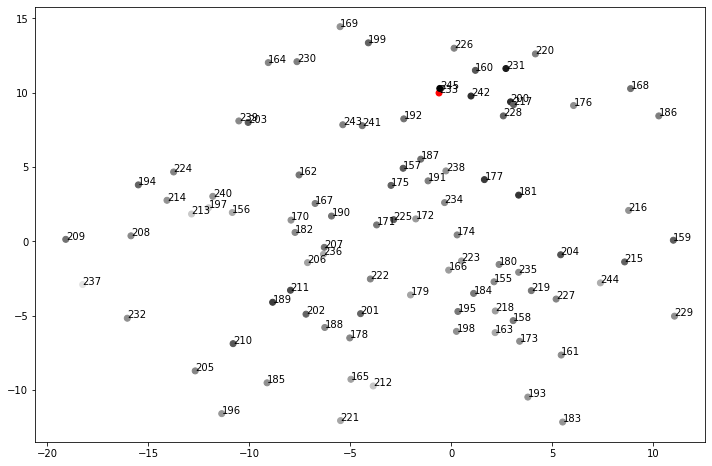

In [264]:
plt.figure(figsize=(12, 8))
for i in range(len(tsne_res[155:246])):
    x=tsne_res[i+155][0]
    y=tsne_res[i+155][1]
    plt.text(x, y, i+155, fontsize=10, color="black")

plt.scatter(tsne_res[155:246][:, 0], tsne_res[155:246][:, 1], color=df_plot.color)
plt.savefig("./images/road_tsne.png", dpi=300, bbox_inches="tight")
plt.show();